In [ ]:
import os
import pandas as pd
import numpy as np
import json
import argparse

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import permutation_test
from scipy.stats import ttest_1samp
from scipy.stats import ttest_ind
from statsmodels.stats import multitest

from tfsemb_class import tsne, save_pickle, add_speech
from tfsplt_encoding import get_cmap_smap, aggregate_data, organize_data
from tfsplt_utils import read_folder, load_pickle, get_con_color
from tfsplt_brainmap import get_sigelecs, Colorbar, make_brainmap
from tfsplt_brainmap_cat import make_brainmap_cat

In [ ]:
MODELS = ["gpt-neo-125M", "gpt-neo-1.3B", "gpt-neo-2.7B", "gpt-neox-20b"]

MODEL_LAYERS = { # model: [first, mid, last, best-mia, best1, best2]
    "gpt-neo-125M":[0,6,12,10,8,8],
    "gpt-neo-1.3B":[0,12,24,22,12,10],
    "gpt-neo-2.7B":[0,16,32,18,12,12],
    "gpt-neox-20b":[0,22,44,14,17,9],
}

LAYERS_DICT = {
    "first": [0,0,0,0],
    "mid": [6,12,16,22],
    "last": [12,24,32,44],
    "best": [10,22,18,14]
}

## Encoding Layers

Read data

In [ ]:
load_sid = 777
key = "comp"
# paths = "../data/encoding/podcast/20231001-gpt-neo/kw-podcast-full-777-%s-lag2k-25-all-2048-%s/kw-200ms-all-777/*_%s.csv"
paths = "../data/encoding/podcast/20231002-gpt-neo-n/kw-podcast-full-777-%s-lag2k-25-all-shift-emb-2048-%s/kw-200ms-all-777/*_%s.csv"

data = []
for model_idx, model in enumerate(MODEL_LAYERS):
  layer_first = MODEL_LAYERS[model][0]
  layer_last = MODEL_LAYERS[model][2]
  for layer in np.arange(0,layer_last + 1):
      fname = paths % (model, f"{layer:02}", key)
      data = read_folder(
          data,
          fname,
          {},
          (load_sid, key),
          load_sid,
          key,
          model,
          f"{layer:02}",
          True,
      )
df = pd.concat(data)

Process df

In [ ]:
df.drop(columns=["sid","key"], inplace=True, errors="ignore")
df["max"] = df.loc[:,(np.arange(0,161))].max(axis=1)
df["label2"] = df.label2.astype(int)
df["layer_ratio"] = df.loc[:,("label1","label2")].groupby("label1").transform(lambda x: (x / max(x) * 100))

Layer max corr (get max across lags per elec, then average max)

In [ ]:
df_max = df.loc[:,("label1","label2","layer_ratio","max",)]

layer_means = df_max.groupby(["label1","label2"]).mean()
layer_sems = df_max.groupby(["label1","label2"]).sem()
layer_means.reset_index(inplace=True)
layer_sems.reset_index(inplace=True)


Layer max corr2 (average each lag across electrodes, then get max lag)

In [ ]:
layer_means = df.groupby(["label1","label2"]).mean()
layer_means["max"] = layer_means.loc[:,(np.arange(0,161))].max(axis=1)
layer_means["sem"] = layer_means.loc[:,(np.arange(0,161))].sem(axis=1)
layer_means.reset_index(inplace=True)

layer_sems = pd.DataFrame({
    "label1":layer_means.label1,
    "label2":layer_means.label2,
    "layer_ratio":layer_means.layer_ratio,
    "max":layer_means["sem"]
    })
layer_means = layer_means.loc[:,("label1","label2","layer_ratio","max")]

Get best layer

In [ ]:
for line, subdf in layer_means.groupby("label1"):
    print(line, subdf["max"].max(), layer_means.loc[subdf["max"].idxmax(),"label2"])

Plot encoding max per layer

In [ ]:
lags = np.arange(-2000,2001,25)
fig, axes = plt.subplots(2,1, figsize=(20,20))
alpha = 0.2
lw = 3
markersize = 15
fontsize = 25
ticksize = 20

# for (line1, subdf1),(line2, subdf2) in zip(layer_means.groupby("label1", axis=0),layer_sems.groupby("label1",axis=0)):
for model in MODEL_LAYERS:
    subdf1 = layer_means[layer_means.label1 == model]
    subdf2 = layer_sems[layer_sems.label1 == model]
    axes[0].fill_between(
        subdf1["layer_ratio"],
        subdf1["max"] - subdf2["max"],
        subdf1["max"] + subdf2["max"],
        alpha=alpha,
    )
    axes[0].plot(
        subdf1["layer_ratio"],
        subdf1["max"],
        # label=line1,
        label=model,
        lw=lw,
        marker=".",
        markersize=markersize
    )
    axes[1].fill_between(
        subdf1["label2"],
        subdf1["max"] - subdf2["max"],
        subdf1["max"] + subdf2["max"],
        alpha=alpha,
    )
    axes[1].plot(
        subdf1["label2"],
        subdf1["max"],
        # label=line1,
        label=model,
        lw=lw
    )
axes[0].set_xlabel("Layers Percentage %",fontsize=fontsize)
axes[0].set_ylabel("Max Correlation (r)",fontsize=fontsize)
axes[1].set_xlabel("Layers",fontsize=fontsize)
axes[1].set_ylabel("Max Correlation (r)",fontsize=fontsize)
axes[0].tick_params(axis="both", which="major", labelsize=ticksize)
axes[1].tick_params(axis="both", which="major", labelsize=ticksize)
plt.savefig("../mia2.jpeg")

## Data Loading

In [ ]:
max_cor_0 = pd.read_csv("../data/plotting/paper-mia/AA_gpt-neo-125M_elec_max_corr.csv", index_col=0)
max_cor_1 = pd.read_csv("../data/plotting/paper-mia/AA_gpt-neo-1.3B_elec_max_corr.csv", index_col=0)
max_cor_2 = pd.read_csv("../data/plotting/paper-mia/AA_gpt-neo-2.7B_elec_max_corr.csv", index_col=0)
max_cor_3 = pd.read_csv("../data/plotting/paper-mia/AA_gpt-neox-20b_elec_max_corr.csv", index_col=0)

## Best Layer Max Corr

In [ ]:
class Args(argparse.Namespace):
  main_dir = "../data/plotting/brainplot/" # loads coordinate and brain surface files
  project = "podcast"
  sid = [777] # subjects
  keys = ["comp"] # comprehension and/or production
  sig_elec_file = ["../data/plotting/sig-elecs/podcast_160.csv"]
  brain_type = "ave" # average brain
  hemisphere = "left" # only plot left hemisphere
  outfile = "../podcast.svg"

args = Args()

# args.color_split = [Colorbar(colorscale="hot",bar_min=0,bar_max=0.4,title="max encoding performance (r)")]
args.color_split = [Colorbar(colorscale="viridis",bar_min=0,bar_max=0.4,title="max encoding performance (r)")]

# Brain Map Plots
model_num = 3
model_df = max_cor_3.copy()
model_df["electrode"] =  model_df.elec_name.str.replace("_comp","")
model_df["subject"] = model_df.electrode.str.split("_", n=1, expand=True)[0]
model_df["effect"] =  model_df.max_corr

df_plot = model_df.loc[model_df.layer == LAYERS_DICT["best"][model_num], ("subject","electrode", "effect")]
fig = make_brainmap(args, df_plot, args.outfile) # plot png

## Best Layer Max Corr Diff

In [ ]:
class Args(argparse.Namespace):
  main_dir = "../data/plotting/brainplot/" # loads coordinate and brain surface files
  project = "podcast"
  sid = [777] # subjects
  keys = ["comp"] # comprehension and/or production
  sig_elec_file = ["../data/plotting/sig-elecs/podcast_160.csv"]
  brain_type = "ave" # average brain
  hemisphere = "left" # only plot left hemisphere
  outfile = "../podcast-%s.svg"

args = Args()

# Colorsplit
pos_bar = Colorbar(title="Δ corr pos",colorscale=[[0, "rgb(255,248,240)"], [1, "rgb(255,0,0)"]],bar_min = 0,bar_max=0.15)
neg_bar = Colorbar(title="Δ corr neg",colorscale=[[0, "rgb(0,0,255)"], [1, "rgb(240,248,255)"]],bar_min=-0.15,bar_max=0)
args.color_split = [neg_bar,0,pos_bar]

# Brain Map Plots
for layer_type in LAYERS_DICT:
  if layer_type != "best":
    continue
  print(layer_type)
  # calculate difference
  model_0 = max_cor_0.loc[max_cor_0.layer == LAYERS_DICT[layer_type][0],("elec_name","max_corr")]
  model_1 = max_cor_1.loc[max_cor_1.layer == LAYERS_DICT[layer_type][1],("elec_name","max_corr")]
  model_2 = max_cor_2.loc[max_cor_2.layer == LAYERS_DICT[layer_type][2],("elec_name","max_corr")]
  model_3 = max_cor_3.loc[max_cor_3.layer == LAYERS_DICT[layer_type][3],("elec_name","max_corr")]
  model_2.sort_values(by="elec_name",inplace=True)
  model_3.sort_values(by="elec_name",inplace=True)
  model_3 = model_3.assign(max_corr2 = model_1.max_corr)
  model_3 = model_3.assign(effect = model_3.max_corr - model_3.max_corr2)
  # format datum
  model_3["electrode"] =  model_3.elec_name.str.replace("_comp","")
  model_3["subject"] = model_3.electrode.str.split("_", n=1, expand=True)[0]

  df_plot = model_3.loc[:, ("subject","electrode", "effect")]
  fig = make_brainmap(args, df_plot, args.outfile % layer_type) # plot png

## Max Corr per Layer

In [ ]:
class Args(argparse.Namespace):
  main_dir = "../data/plotting/brainplot/" # loads coordinate and brain surface files
  project = "podcast"
  sid = [777] # subjects
  keys = ["comp"] # comprehension and/or production
  sig_elec_file = ["../data/plotting/sig-elecs/podcast_160.csv"]
  brain_type = "ave" # average brain
  hemisphere = "left" # only plot left hemisphere
  outfile = "../podcast-%s.png"

args = Args()

args.color_split = [Colorbar(colorscale="viridis",bar_max=0.45)]

# Brain Map Plots
model_num = 3
model_df = max_cor_4.copy()
model_df["electrode"] =  model_df.elec_name.str.replace("_comp","")
model_df["subject"] = model_df.electrode.str.split("_", n=1, expand=True)[0]
model_df["effect"] =  model_df.max_corr

for layer in np.arange(LAYERS_DICT["first"][model_num],LAYERS_DICT["last"][model_num] + 1):
  print(layer)
  df_plot = model_df.loc[model_df.layer == layer, ("subject","electrode", "effect")]
  fig = make_brainmap(args, df_plot, args.outfile % f"{layer:02}") # plot png

## Max Corr

In [ ]:
class Args(argparse.Namespace):
  main_dir = "../data/plotting/brainplot/" # loads coordinate and brain surface files
  project = "podcast"
  sid = [777] # subjects
  keys = ["comp"] # comprehension and/or production
  sig_elec_file = ["../data/plotting/sig-elecs/podcast_160.csv"]
  brain_type = "ave" # average brain
  hemisphere = "left" # only plot left hemisphere
  outfile = "../podcast_%s.png"

args = Args()

args.color_split = [Colorbar(title="best layer",colorscale="viridis",bar_max=0.45, bar_min=0)]

# df_plot = max_cor_1.sort_values(["max_corr"], ascending=False).groupby("elec_name").first()
# df_plot.reset_index(inplace=True)
# df_plot["effect"] = df_plot.max_corr
# df_plot["electrode"] =  df_plot.elec_name.str.replace("_comp","")
# df_plot["subject"] = df_plot.electrode.str.split("_", n=1, expand=True)[0]
# df_plot = df_plot.loc[:, ("subject","electrode", "effect")]
# fig = make_brainmap(args, df_plot, args.outfile) # plot png

df_plot = df.sort_values(["max"],ascending=False).groupby(["label1","electrode"]).first()
df_plot.reset_index(inplace=True)
df_plot["effect"] = df_plot["max"]
df_plot["subject"] = df_plot.electrode.str.split("_", n=1, expand=True)[0]
for model, subdf in df_plot.groupby("label1", axis=0):
    subdf_plot = subdf.loc[:, ("subject","electrode", "effect")]
    print(subdf_plot.effect.mean())
    # fig = make_brainmap(args, subdf_plot, args.outfile % model) # plot png

## Max Corr Diff

In [ ]:
class Args(argparse.Namespace):
  main_dir = "../data/plotting/brainplot/" # loads coordinate and brain surface files
  project = "podcast"
  sid = [777] # subjects
  keys = ["comp"] # comprehension and/or production
  sig_elec_file = ["../data/plotting/sig-elecs/podcast_160.csv"]
  brain_type = "ave" # average brain
  hemisphere = "left" # only plot left hemisphere
  outfile = "../podcast-diff-%s.png"

args = Args()

# Colorsplit
pos_bar = Colorbar(title=f"Δ % corr pos",colorscale=[[0, "rgb(255,248,240)"], [1, "rgb(255,0,0)"]],bar_min=0,bar_max=30)
neg_bar = Colorbar(title=f"Δ % corr neg",colorscale=[[0, "rgb(0,0,255)"], [1, "rgb(240,248,255)"]],bar_min=-30,bar_max=0)
args.color_split = [neg_bar,0,pos_bar]


# df_plot = max_cor_3.sort_values(["max_corr"], ascending=False).groupby("elec_name").first()
# df_plot.reset_index(inplace=True)
# df_plot2 = max_cor_2.sort_values(["max_corr"], ascending=False).groupby("elec_name").first()
# df_plot2.reset_index(inplace=True)
# df_plot["max_corr2"] = df_plot2.max_corr
# df_plot["effect"] = df_plot.max_corr - df_plot.max_corr2
# df_plot["electrode"] =  df_plot.elec_name.str.replace("_comp","")
# df_plot["subject"] = df_plot.electrode.str.split("_", n=1, expand=True)[0]
# df_plot = df_plot.loc[:, ("subject","electrode", "effect")]
# fig = make_brainmap(args, df_plot, args.outfile) # plot png

df_plot = df.sort_values(["max"],ascending=False).groupby(["label1","electrode"]).first()
df_plot.reset_index(inplace=True)
df_plot = df_plot.loc[:,("label1","label2","electrode","max")]

df_base = df_plot.loc[df_plot["label1"] == "gpt-neo-2.7B",("electrode","max")].copy()
df_plot = df_plot.merge(df_base,left_on="electrode",right_on="electrode",how="outer")
df_plot["effect"] = df_plot["max_x"] / df_plot["max_y"] * 100 - 100
df_plot["subject"] = df_plot.electrode.str.split("_", n=1, expand=True)[0]
for model, subdf in df_plot.groupby("label1", axis=0):
  if model != "gpt-neox-20b":
    continue
  subdf_plot = subdf.loc[:, ("subject","electrode", "effect")]
  print(model, subdf_plot.effect.mean())
  fig = make_brainmap(args, subdf_plot, args.outfile % model) # plot png


## Max Corr Layer

In [ ]:
class Args(argparse.Namespace):
  main_dir = "../data/plotting/brainplot/" # loads coordinate and brain surface files
  project = "podcast"
  sid = [777] # subjects
  keys = ["comp"] # comprehension and/or production
  sig_elec_file = ["../data/plotting/sig-elecs/podcast_160.csv"]
  brain_type = "ave" # average brain
  hemisphere = "left" # only plot left hemisphere
  outfile = "../podcast_%s.png"

args = Args()

# args.color_split = [Colorbar(title="Layer with best correlation (relative %)",colorscale="agsunset",bar_max=1, bar_min=0)]
args.color_split = [Colorbar(title="Layer with best correlation (relative %)",colorscale="inferno",bar_max=100, bar_min=0)]

# model_num = 3
# df_plot = max_cor_3.sort_values(["max_corr"], ascending=False).groupby("elec_name").first()
# df_plot.reset_index(inplace=True)
# min = LAYERS_DICT["first"][model_num]
# max = LAYERS_DICT["last"][model_num]
# df_plot["effect"] = df_plot.layer / (max - min)
# # df_plot["effect"] = df_plot.layer
# df_plot["electrode"] =  df_plot.elec_name.str.replace("_comp","")
# df_plot["subject"] = df_plot.electrode.str.split("_", n=1, expand=True)[0]
# df_plot = df_plot.loc[:, ("subject","electrode", "effect")]
# fig = make_brainmap(args, df_plot, args.outfile) # plot png

df_plot = df.sort_values(["max"],ascending=False).groupby(["label1","electrode"]).first()
df_plot.reset_index(inplace=True)
df_plot["effect"] = df_plot.layer_ratio
df_plot["subject"] = df_plot.electrode.str.split("_", n=1, expand=True)[0]
for model, subdf in df_plot.groupby("label1", axis=0):
    subdf_plot = subdf.loc[:, ("subject","electrode", "effect")]
    print(subdf_plot["effect"].mean())
    fig = make_brainmap(args, subdf_plot, args.outfile % model) # plot png

## Area brainmap

In [ ]:
class Args(argparse.Namespace):
  main_dir = "../data/plotting/brainplot/" # loads coordinate and brain surface files
  project = "podcast"
  sid = [777] # subjects
  keys = ["comp"] # comprehension and/or production
  sig_elec_file = ["../data/plotting/sig-elecs/podcast_160.csv"]
  brain_type = "ave" # average brain
  hemisphere = "left" # only plot left hemisphere
  outfile = "../podcast.png"

args = Args()
color_list = ["rgb(55,126,184)","rgb(255,127,0)","rgb(77,175,74)","rgb(152,78,163)"]
args.colors = color_list

area_file = "../data/plotting/paper-mia/area_electrodes.json"
with open(area_file, "r") as j:
    area_dict = json.loads(j.read())

area_df = []
for area in area_dict:
    for elec in area_dict[area]:
        area_df.append([elec, area])

area_df = pd.DataFrame(area_df)
area_df.columns = ["electrode","effect"]
area_df["subject"] = area_df.electrode.str.split("_", n=1, expand=True)[0]
fig = make_brainmap_cat(args, area_df, args.outfile) # plot png


## Box / Violin Plots

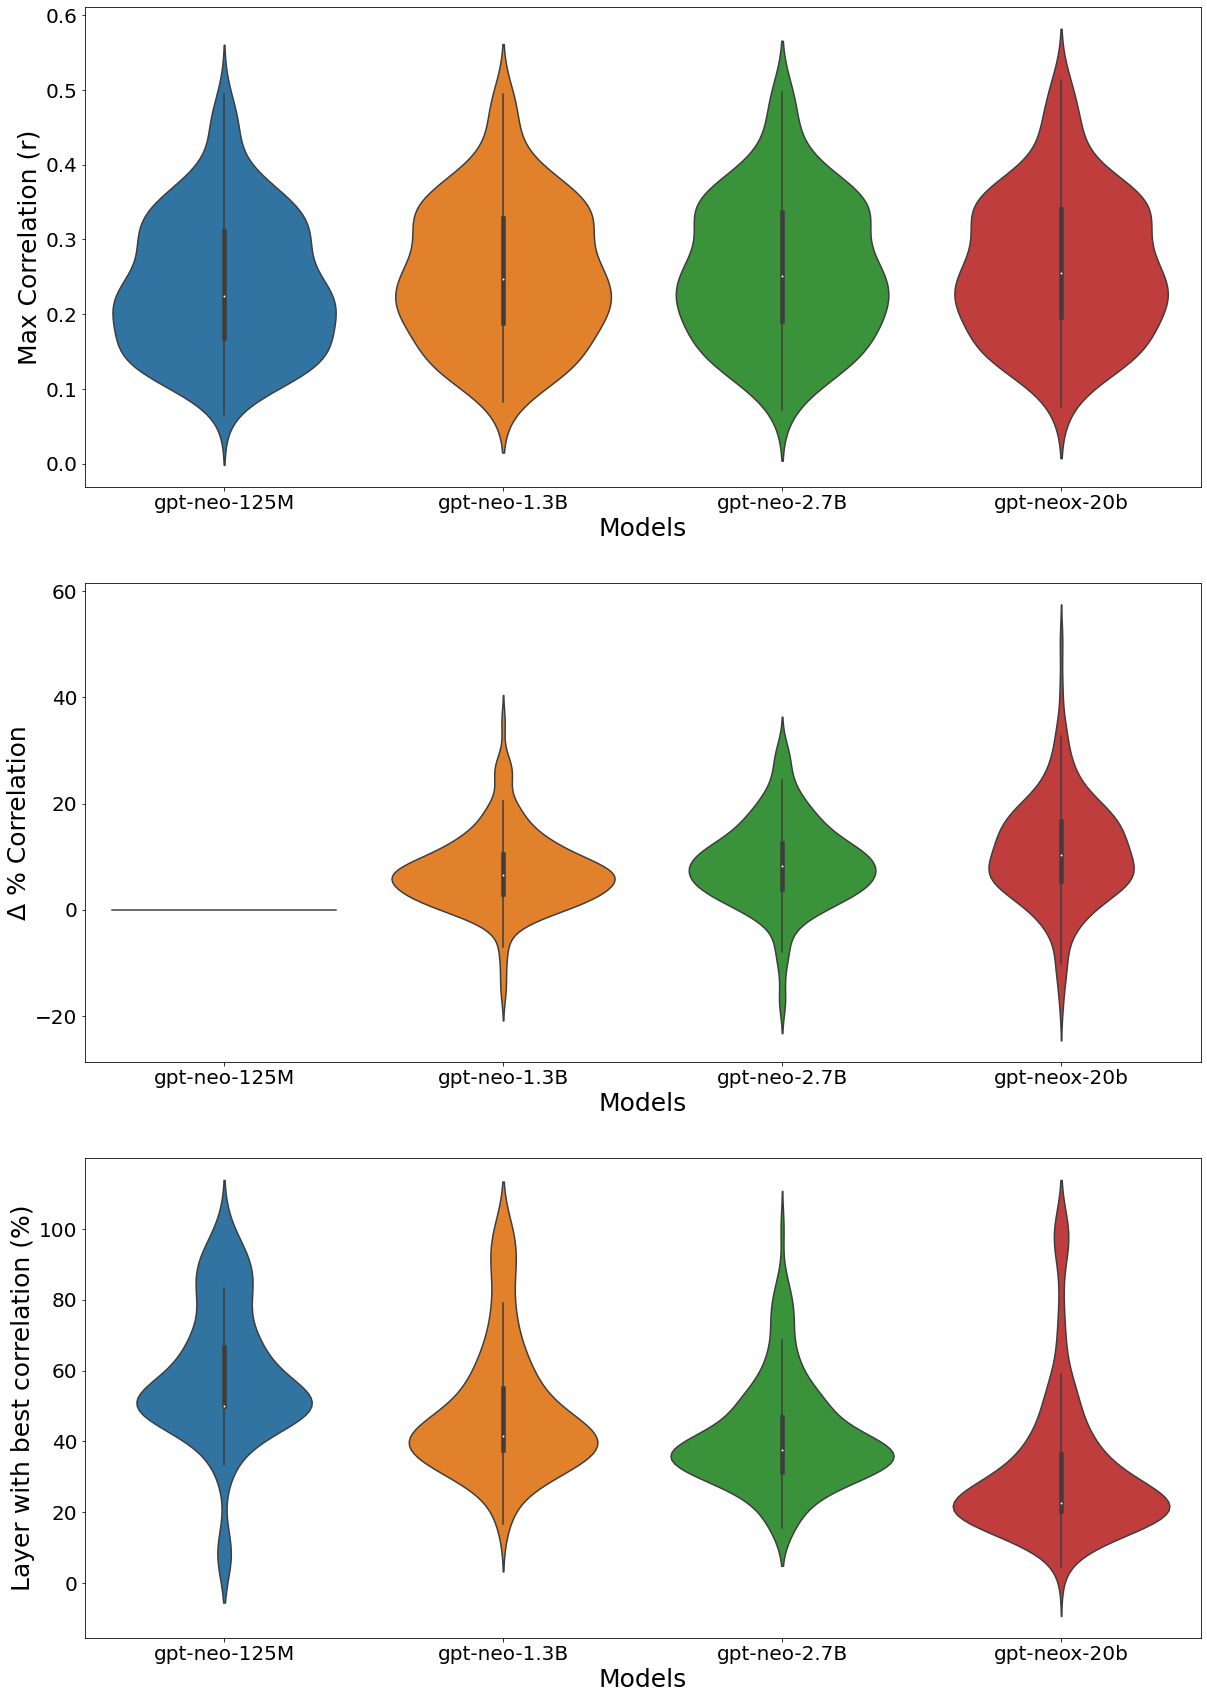

In [13]:
alpha = 0.2
lw = 3
markersize = 15
fontsize = 25
ticksize = 20

df_plot = df.sort_values(["max"],ascending=False).groupby(["label1","electrode"]).first()
df_plot.reset_index(inplace=True)


df_base = df_plot.loc[df_plot["label1"] == "gpt-neo-125M",("electrode","max")].copy()
df_plot = df_plot.merge(df_base,left_on="electrode",right_on="electrode",how="outer")
df_plot["improve"] = df_plot["max_x"] / df_plot["max_y"] * 100 - 100

fig, axes = plt.subplots(3,1, figsize=(20,30))

sns.violinplot(data=df_plot,x="label1",y="max_x",ax=axes[0],order=MODELS)
sns.violinplot(data=df_plot,x="label1",y="improve",ax=axes[1],order=MODELS)
sns.violinplot(data=df_plot,x="label1",y="layer_ratio",ax=axes[2],order=MODELS)

axes[0].set_xlabel("Models",fontsize=fontsize)
axes[0].set_ylabel("Max Correlation (r)",fontsize=fontsize)
axes[1].set_xlabel("Models",fontsize=fontsize)
axes[1].set_ylabel("Δ % Correlation",fontsize=fontsize)
axes[2].set_xlabel("Models",fontsize=fontsize)
axes[2].set_ylabel("Layer with best correlation (%)",fontsize=fontsize)
axes[0].tick_params(axis="both", which="major", labelsize=ticksize)
axes[1].tick_params(axis="both", which="major", labelsize=ticksize)
axes[2].tick_params(axis="both", which="major", labelsize=ticksize)

plt.savefig("../model_layers.jpeg")
